# Hypothesis Testing in Healthcare: Drug Safety

A pharmaceutical company GlobalXYZ has just completed a randomized controlled drug trial. To promote transparency and reproducibility of the drug's outcome, they (GlobalXYZ) have presented the dataset to your organization, a non-profit that focuses primarily on drug safety.

The dataset provided contained five adverse effects, demographic data, vital signs, etc. Your organization is primarily interested in the drug's adverse reactions. It wants to know if the adverse reactions, if any, are of significant proportions. It has asked you to explore and answer some questions from the data.

The dataset `drug_safety.csv` was obtained from [Hbiostat](https://hbiostat.org/data/) courtesy of the Vanderbilt University Department of Biostatistics. It contained five adverse effects: headache, abdominal pain, dyspepsia, upper respiratory infection, chronic obstructive airway disease (COAD), demographic data, vital signs, lab measures, etc. The ratio of drug observations to placebo observations is 2 to 1.

For this project, the dataset has been modified to reflect the presence and absence of adverse effects `adverse_effects` and the number of adverse effects in a single individual `num_effects`.

The columns in the modified dataset are: 

| Column | Description |
|--------|-------------|
|`sex` | The gender of the individual |
|`age` | The age of the individual |
|`week` | The week of the drug testing |
|`trx` | The treatment (Drug) and control (Placebo) groups | 
|`wbc` | The count of white blood cells |
|`rbc` | The count of red blood cells |
|`adverse_effects` | The presence of at least a single adverse effect |
|`num_effects` | The number of adverse effects experienced by a single individual |

The original dataset can be found [here](https://hbiostat.org/data/repo/safety.rda).

Your organization has asked you to explore and answer some questions from the data collected. See the project instructions.

In [23]:
# Import packages
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
drug_safety = pd.read_csv("drug_safety.csv")

# Start coding here...
drug_safety.head(5)

,age,sex,trx,week,wbc,rbc,adverse_effects,num_effects
0,62,male,Drug,0,7.3,5.1,No,0
1,62,male,Drug,1,NaN,NaN,No,0
2,62,male,Drug,12,5.6,5.0,No,0
3,62,male,Drug,16,NaN,NaN,No,0
4,62,male,Drug,2,6.6,5.1,No,0


In [12]:
# Changing values in adverse_effect from yes/no to 1/0
rep = {'No':0,
      'Yes':1}
drug_safety['adverse_effects'] = drug_safety['adverse_effects'].replace(rep)

In [13]:
# Looking for proportion of our groups drug/placebo
drug_safety['trx'].value_counts(normalize = True)

Drug       0.666149
Placebo    0.333851
Name: trx, dtype: float64

Initiate our zero and alternative hypothesis:\
Ho: p1-p2 = 0, there is no significant difference between adverse effects in drug and placebo groups.\
Ha: p1-p2 ≠ 0 (not equal), there is significant difference between adverse effects in drug and placebo groups.\
\
Statistical significance: 5% (0.05)

In [15]:
# filtering for 2 datasets and finding the mean of adverse_effects for each dataset
drug = drug_safety[drug_safety['trx'] == 'Drug']
placebo = drug_safety[drug_safety['trx'] == 'Placebo']
mean_drug = drug['adverse_effects'].mean()
mean_placebo = placebo['adverse_effects'].mean()

In [16]:
# Prepearing variables for our function proportions_ztest()

count = np.array([sum(drug['adverse_effects']), sum(placebo['adverse_effects'])])
nobs = np.array([len(drug['adverse_effects']), len(placebo['adverse_effects'])])

ztest = proportions_ztest(count, nobs)

two_sample_p_value = ztest[1]
two_sample_p_value

0.9639333330262475

Z stats = 0.0452182684494942   -  It represents how many standard deviations the observed difference in proportions is from the expected difference under the null hypothesis.

P-value =  0.9639333330262475 - It indicates the probability of observing the observed difference in proportions (or a more extreme difference) if the null hypothesis (no difference in proportions) is true.

P-value > Statistical significance - 0.96 > 0.05 - fail to reject the Ho

In [17]:
# Find out if the number of adverse effects is independent of the treatment and control groups, saving as a variable called num_effects_p_value containing a p-value.
#drug_safety.groupby(['trx', 'num_effects']).size().reset_index(name = 'count')

num_effects_groups = pg.chi2_independence(data=drug_safety, x="num_effects", y="trx")
num_effects_p_value = num_effects_groups[2]["pval"][0]

num_effects_p_value

0.6150123339426765

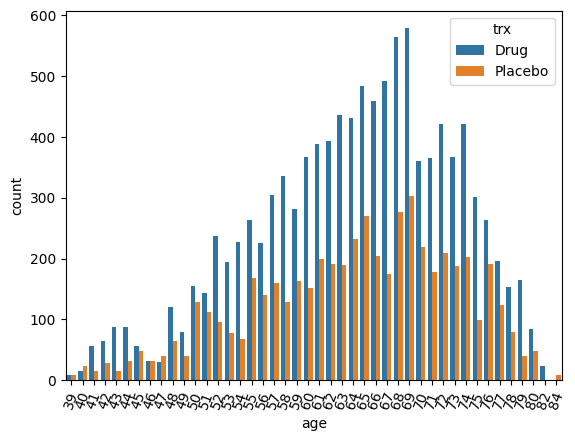

In [18]:
# Examine if there is a significant difference between the ages of the Drug and Placebo groups, storing the p-value of your test in a variable called age_group_effects_p_value.
age_distr = drug_safety.groupby(['trx', 'age']).size().reset_index(name = 'count')


sns.barplot(
    age_distr, x="age", y ="count", hue = "trx")
plt.xticks(rotation=70)
plt.show()


In [19]:
#To formally test for a difference in distributions of age between the two trx groups you can perform a Shapiro-Wilks test using pengouin.normality().
#This function takes three arguments - data, dv (dependent variable), and group.

normality_test = pg.normality(drug_safety, dv = "age", group = "trx", method = 'shapiro', alpha = 0.05)
normality_test

,W,pval,normal
trx,,,
Drug,0.976785,2.189152e-38,False
Placebo,0.975595,2.224950e-29,False


In [30]:
# Data distributed not normally , so there is sense in performing Mann-Whitney U test.
#The Mann-Whitney U Test assesses whether two sampled groups are likely to derive from the same population, and essentially asks; do these two populations have the same shape with regards to their data?

trx_drug = drug_safety[drug_safety['trx'] == 'Drug']['age']
trx_placebo = drug_safety[drug_safety['trx'] == 'Placebo']['age']

test_png = pg.mwu(trx_drug,trx_placebo)
age_group_effects_p_value = test_png['p-val'][0]
age_group_effects_p_value
test_png

,U-val,alternative,p-val,RBC,CLES
MWU,29149339.5,two-sided,0.256963,-0.01093,0.505465


P-val = 0.25696267 , we fail to reject the null hypothesis. Age distribution is identical between the two groups.

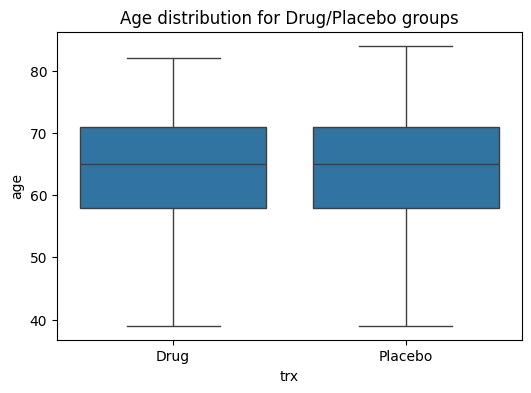

In [39]:
plt.figure(figsize=(6, 4))
sns.boxplot(data = drug_safety, x = 'trx', y = 'age')
plt.title('Age distribution for Drug/Placebo groups')
plt.show()